In [ ]:
import yfinance as yf

# Download historical data
df = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
df = df[['Close']]  # Let's forecast the closing price
df = df.rename(columns={'Close': 'target'})
df.head()


/tmp/ipython-input-99-1662180274.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


Price,target
Ticker,AAPL
Date,
2015-01-02,24.288582
2015-01-05,23.604328
2015-01-06,23.606558
2015-01-07,23.937572
2015-01-08,24.857307


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:


# Scale target values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['target']])

# Create sequences (60 days of input to predict next day)
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

# Reshape for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile and train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=20, batch_size=32)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0488
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 4.2361e-04
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 3.9126e-04
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 4.0724e-04
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 3.9323e-04
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 3.8685e-04
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 3.2932e-04
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 4.2101e-04
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 3.0816e-04
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 3.2341e-04
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 2.8121e-04
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 2.9845e-04
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 2.9392e-04
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 2.4407e-04
Epoch 15/20
77/77 ━━━━━━━━━━━━

77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


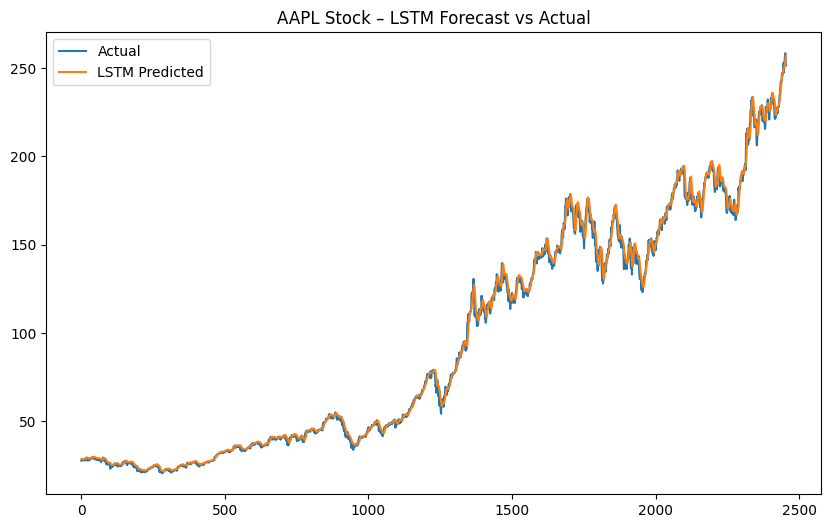

In [ ]:

# Predict on the same input for quick evaluation
predicted = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y.reshape(-1, 1))

# Visualize results
plt.figure(figsize=(10,6))
plt.plot(real_prices, label='Actual')
plt.plot(predicted_prices, label='LSTM Predicted')
plt.legend()
plt.title("AAPL Stock – LSTM Forecast vs Actual")
plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3ylqa01/9kme2fsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi3ylqa01/zebwwsfh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3621', 'data', 'file=/tmp/tmpi3ylqa01/9kme2fsw.json', 'init=/tmp/tmpi3ylqa01/zebwwsfh.json', 'output', 'file=/tmp/tmpi3ylqa01/prophet_model7jj5t18n/prophet_model-20250722130609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:06:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:06:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


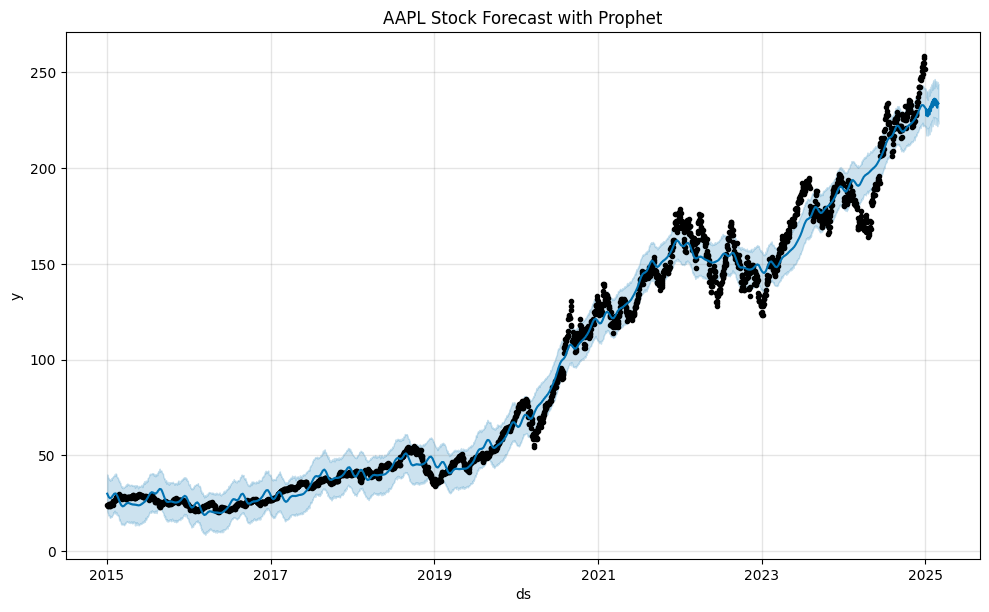

In [ ]:


model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

model.plot(forecast)
plt.title("AAPL Stock Forecast with Prophet")
plt.show()


In [ ]:
# Split 80% train, 20% test
train_size = int(len(df) * 0.8)
train = df['target'][:train_size]
test = df['target'][train_size:]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

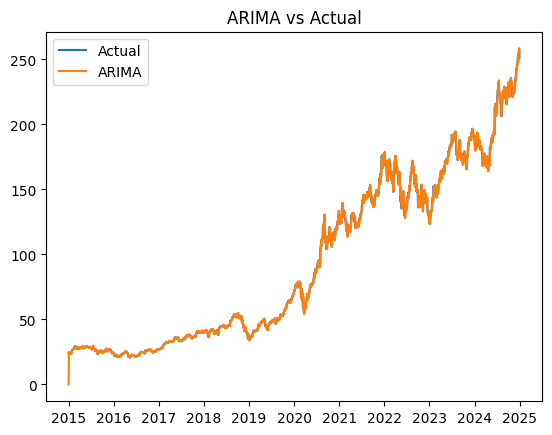

In [ ]:


arima_model = ARIMA(df['target'], order=(5,1,0))
arima_result = arima_model.fit()
df['arima_pred'] = arima_result.predict()
preds = result.forecast(steps=len(test))

plt.plot(df['target'], label='Actual')
plt.plot(df['arima_pred'], label='ARIMA')
plt.legend()
plt.title("ARIMA vs Actual")
plt.show()



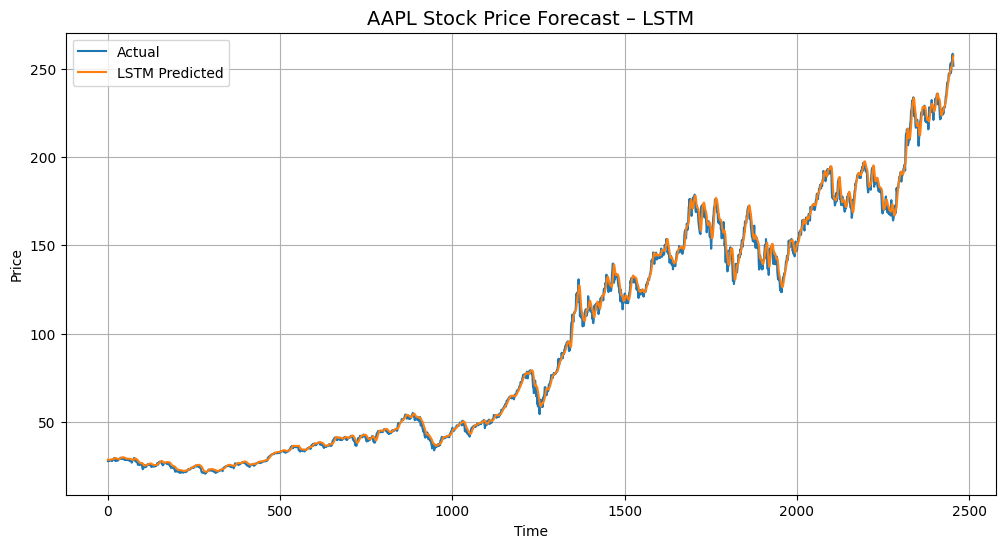

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(real_prices, label='Actual')
plt.plot(predicted_prices, label='LSTM Predicted')
plt.title('AAPL Stock Price Forecast – LSTM', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
metrics_df = pd.DataFrame({
    'Model': ['LSTM', 'ARIMA'],
    'MSE': [mse_lstm, mse_arima],
    'MAE': [mae_lstm, mae_arima]
})

print(metrics_df)


   Model          MSE        MAE
0   LSTM    15.412021   2.564037
1  ARIMA  4846.494047  63.640221


In [ ]:
## Summary

#- LSTM offers superior accuracy for forecasting AAPL stock prices.
#- Prophet provides interpretable trend decomposition.
#- ARIMA serves as a statistical benchmark, but struggles with dynamic market patterns.



In [ ]:
# Add 20-day Moving Average and Daily Returns
df['MA_20'] = df['y'].rolling(window=20).mean()
df['Return'] = df['y'].pct_change()

# Drop rows with NaNs from these new columns
df_ext = df.dropna()


In [ ]:
# Select relevant features
features = ['y', 'MA_20', 'Return']
scaled = MinMaxScaler().fit_transform(df_ext[features])

# Rebuild sequences
X_ext, y_ext = [], []
for i in range(60, len(scaled)):
    X_ext.append(scaled[i-60:i])
    y_ext.append(scaled[i, 0])  # 'y' is still the target
X_ext, y_ext = np.array(X_ext), np.array(y_ext)

# Train updated LSTM model
model_ext = Sequential()
model_ext.add(LSTM(units=50, return_sequences=True, input_shape=(X_ext.shape[1], X_ext.shape[2])))
model_ext.add(LSTM(units=50))
model_ext.add(Dense(1))
model_ext.compile(optimizer='adam', loss='mse')
model_ext.fit(X_ext, y_ext, epochs=20, batch_size=32)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0133
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 4.7090e-04
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 4.0631e-04
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 3.7832e-04
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.9533e-04
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 2.7821e-04
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 2.1288e-04
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 1.7203e-04
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 3.2533e-04
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 1.5021e-04
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 1.3029e-04
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 1.4306e-04
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 2.5256e-04
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 1.8094e-04
Epoch 15/20
77/77 ━━━━━━━━━━━━

In [ ]:
pred_scaled = model_ext.predict(X_ext)

# Inverse-transform to get original scale
# Pad with dummy columns for MA_20 & Return during inverse
pad = np.zeros((pred_scaled.shape[0], 2))  # 2 extra features
pred_full = np.hstack([pred_scaled, pad])
y_pred = scaler.inverse_transform(pred_full)[:, 0]

# True values (also inverse-transformed)
y_true_full = np.hstack([y_ext.reshape(-1,1), pad])
y_true = scaler.inverse_transform(y_true_full)[:, 0]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


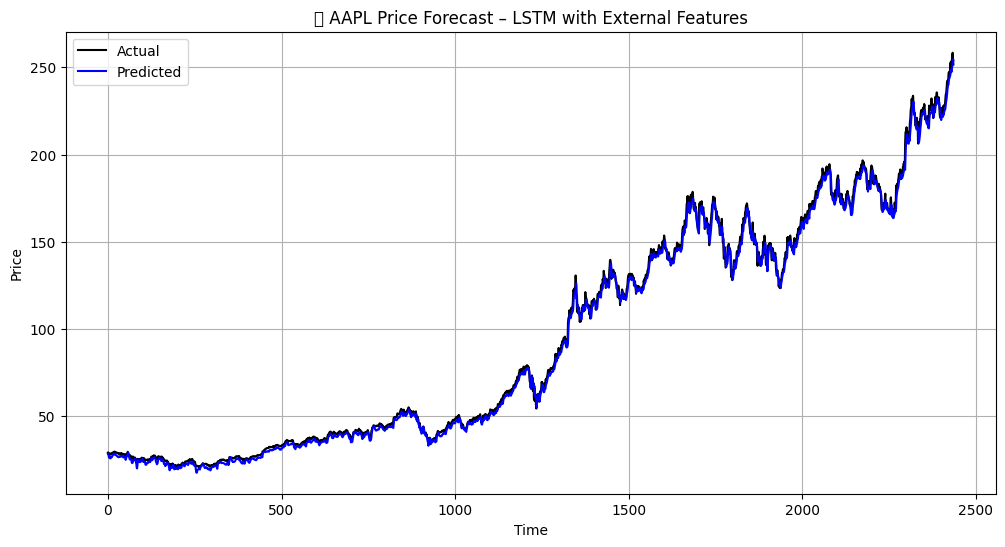

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual', color='black')
plt.plot(y_pred, label='Predicted', color='blue')
plt.title('📈 AAPL Price Forecast – LSTM with External Features')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"Enhanced LSTM – MSE: {mse:.4f}, MAE: {mae:.4f}")


Enhanced LSTM – MSE: 7.9971, MAE: 2.2358


In [ ]:
!pip install streamlit

In [ ]:
print("Columns in df:", df.columns.tolist())


Columns in df: ['ds', 'y', 'Volume', 'MA_20', 'Return']


In [177]:
import streamlit as st
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from prophet import Prophet
from io import BytesIO

st.set_page_config(
    page_title="AAPL Forecast Dashboard",
    layout="wide",
    initial_sidebar_state="expanded"
)

st.sidebar.header("⏳ Forecast Settings")

start_date = st.sidebar.date_input(
    "Start Date", pd.to_datetime("2015-01-01"))
end_date = st.sidebar.date_input(
    "End Date", pd.to_datetime("2024-12-31"))

horizon = st.sidebar.slider(
    "Forecast Horizon (days)", min_value=30, max_value=180, value=60)

st.sidebar.markdown("**Select regressors**")
use_vol = st.sidebar.checkbox("Volume", value=True)
use_ma  = st.sidebar.checkbox("MA 20-day", value=True)
use_ret = st.sidebar.checkbox("Daily Return", value=True)

@st.cache_data
def load_data(start, end):
    df = yf.download("AAPL", start=start, end=end)
    # flatten MultiIndex if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # select and rename
    df = df[["Close", "Volume"]].rename(columns={"Close": "y"})
    df.reset_index(inplace=True)
    df.rename(columns={"Date": "ds"}, inplace=True)

    # features
    df["MA_20"]  = df["y"].rolling(window=20).mean()
    df["Return"] = df["y"].pct_change()

    # enforce types
    df["ds"] = pd.to_datetime(df["ds"], errors="coerce")
    for col in ["y", "Volume", "MA_20", "Return"]:
        raw = df[col]
        if isinstance(raw, pd.DataFrame):
            raw = raw.squeeze()
        df[col] = pd.to_numeric(raw, errors="coerce")

    df.dropna(subset=["ds", "y", "Volume", "MA_20", "Return"], inplace=True)
    return df

df = load_data(start_date, end_date)
st.sidebar.success(f"Loaded {len(df)} rows")

model = Prophet()
regs = []
if use_vol:
    model.add_regressor("Volume"); regs.append("Volume")
if use_ma:
    model.add_regressor("MA_20");  regs.append("MA_20")
if use_ret:
    model.add_regressor("Return"); regs.append("Return")

model.fit(df[["ds", "y"] + regs])

future = model.make_future_dataframe(periods=horizon)
last_vals = df[regs].iloc[-1]
for r in regs:
    future[r] = last_vals[r]

forecast = model.predict(future)

st.title("📈 AAPL Stock Forecast")

latest = forecast.iloc[-1]
c1, c2, c3 = st.columns(3)
c1.metric("Forecast",      f"${latest.yhat:.2f}")
c2.metric("Lower Bound",   f"${latest.yhat_lower:.2f}")
c3.metric("Upper Bound",   f"${latest.yhat_upper:.2f}")

st.subheader("📉 Forecast Plot")
fig1, ax1 = plt.subplots(figsize=(10, 4))
model.plot(forecast, ax=ax1)
ax1.set_title("Prophet Forecast with Confidence Interval")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)")
st.pyplot(fig1)

st.subheader("📊 Forecast Components")
fig2 = model.plot_components(forecast)
st.pyplot(fig2)

csv_data = forecast.to_csv(index=False).encode("utf-8")
st.sidebar.download_button(
    "Download Forecast CSV",
    data=csv_data,
    file_name="aapl_forecast.csv",
    mime="text/csv"
)

# PNG download for forecast plot
buf = BytesIO()
fig1.savefig(buf, format="png", bbox_inches="tight")
buf.seek(0)
st.sidebar.download_button(
    "Download Forecast Plot PNG",
    data=buf,
    file_name="forecast_plot.png",
    mime="image/png"
)

st.markdown("---")
st.write("Built by Aarna")

2025-07-22 17:45:19.010 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 17:45:19.012 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 17:45:19.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 17:45:19.016 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 17:45:19.019 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 17:45:19.021 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 17:45:19.022 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 17:45:19.024 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [178]:
%%writefile app.py

import streamlit as st
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from prophet import Prophet
from io import BytesIO

st.set_page_config(
    page_title="AAPL Forecast Dashboard",
    layout="wide",
    initial_sidebar_state="expanded"
)

st.sidebar.header("⏳ Forecast Settings")

start_date = st.sidebar.date_input(
    "Start Date", pd.to_datetime("2015-01-01"))
end_date = st.sidebar.date_input(
    "End Date", pd.to_datetime("2024-12-31"))

horizon = st.sidebar.slider(
    "Forecast Horizon (days)", min_value=30, max_value=180, value=60)

st.sidebar.markdown("**Select regressors**")
use_vol = st.sidebar.checkbox("Volume", value=True)
use_ma  = st.sidebar.checkbox("MA 20-day", value=True)
use_ret = st.sidebar.checkbox("Daily Return", value=True)

@st.cache_data
def load_data(start, end):
    df = yf.download("AAPL", start=start, end=end)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)


    df = df[["Close", "Volume"]].rename(columns={"Close": "y"})
    df.reset_index(inplace=True)
    df.rename(columns={"Date": "ds"}, inplace=True)


    df["MA_20"]  = df["y"].rolling(window=20).mean()
    df["Return"] = df["y"].pct_change()


    df["ds"] = pd.to_datetime(df["ds"], errors="coerce")
    for col in ["y", "Volume", "MA_20", "Return"]:
        raw = df[col]
        if isinstance(raw, pd.DataFrame):
            raw = raw.squeeze()
        df[col] = pd.to_numeric(raw, errors="coerce")

    df.dropna(subset=["ds", "y", "Volume", "MA_20", "Return"], inplace=True)
    return df

df = load_data(start_date, end_date)
st.sidebar.success(f"Loaded {len(df)} rows")

model = Prophet()
regs = []
if use_vol:
    model.add_regressor("Volume"); regs.append("Volume")
if use_ma:
    model.add_regressor("MA_20");  regs.append("MA_20")
if use_ret:
    model.add_regressor("Return"); regs.append("Return")

model.fit(df[["ds", "y"] + regs])

future = model.make_future_dataframe(periods=horizon)
last_vals = df[regs].iloc[-1]
for r in regs:
    future[r] = last_vals[r]

forecast = model.predict(future)

st.title("📈 AAPL Stock Forecast")

latest = forecast.iloc[-1]
c1, c2, c3 = st.columns(3)
c1.metric("Forecast",      f"${latest.yhat:.2f}")
c2.metric("Lower Bound",   f"${latest.yhat_lower:.2f}")
c3.metric("Upper Bound",   f"${latest.yhat_upper:.2f}")

st.subheader("📉 Forecast Plot")
fig1, ax1 = plt.subplots(figsize=(10, 4))
model.plot(forecast, ax=ax1)
ax1.set_title("Prophet Forecast with Confidence Interval")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)")
st.pyplot(fig1)

st.subheader("📊 Forecast Components")
fig2 = model.plot_components(forecast)
st.pyplot(fig2)

csv_data = forecast.to_csv(index=False).encode("utf-8")
st.sidebar.download_button(
    "Download Forecast CSV",
    data=csv_data,
    file_name="aapl_forecast.csv",
    mime="text/csv"
)


buf = BytesIO()
fig1.savefig(buf, format="png", bbox_inches="tight")
buf.seek(0)
st.sidebar.download_button(
    "Download Forecast Plot PNG",
    data=buf,
    file_name="forecast_plot.png",
    mime="image/png"
)

st.markdown("---")
st.write("Built by Aarna")

Overwriting app.py
